In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0


In [3]:
import scipy
scipy.__version__

'1.3.1'

In [4]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

In [5]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [6]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

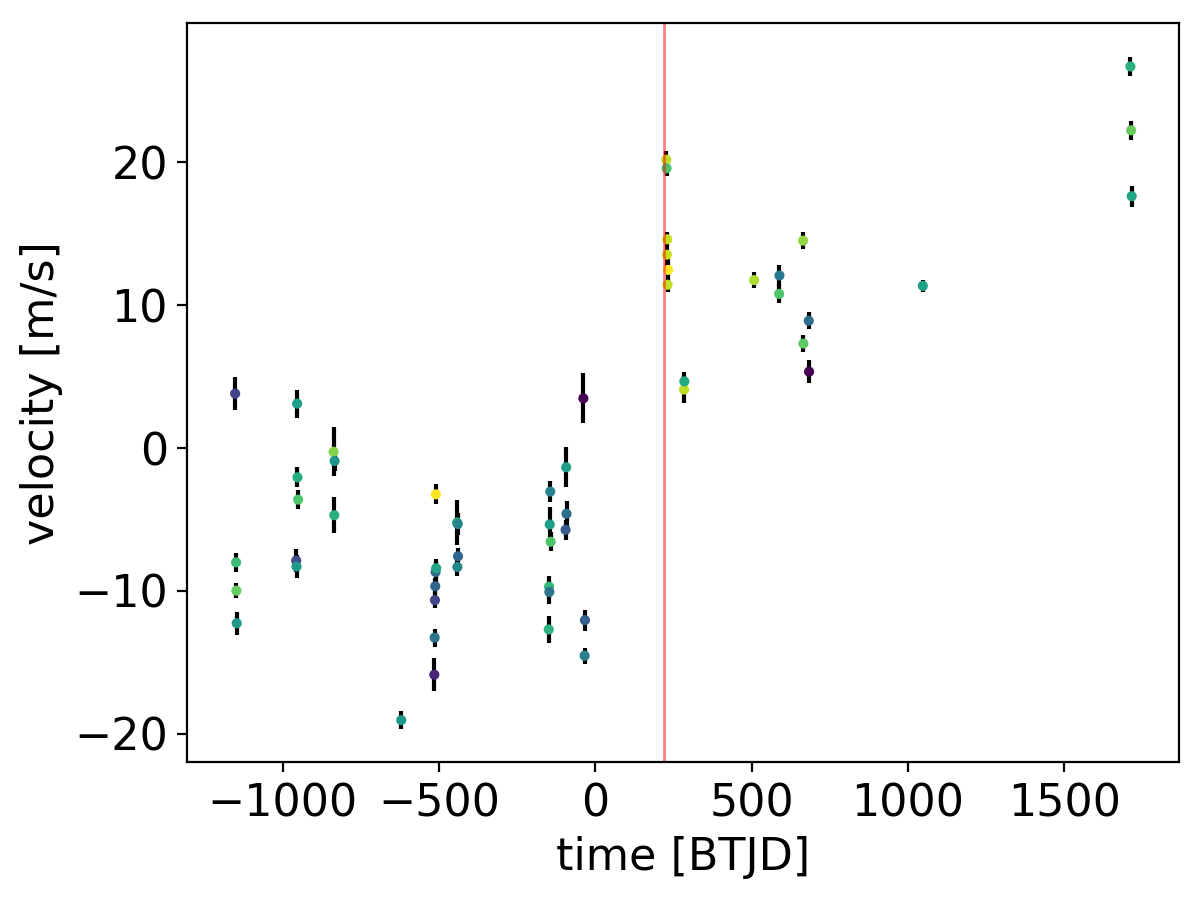

In [7]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)
fwhm_rv = np.ascontiguousarray((df.fwhm - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)


t = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv[~pug], y_rv[~pug], c=df.bis[~pug], s=7)
plt.scatter(x_rv[pug], y_rv[pug], c=df.bis[pug], s=7)
plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

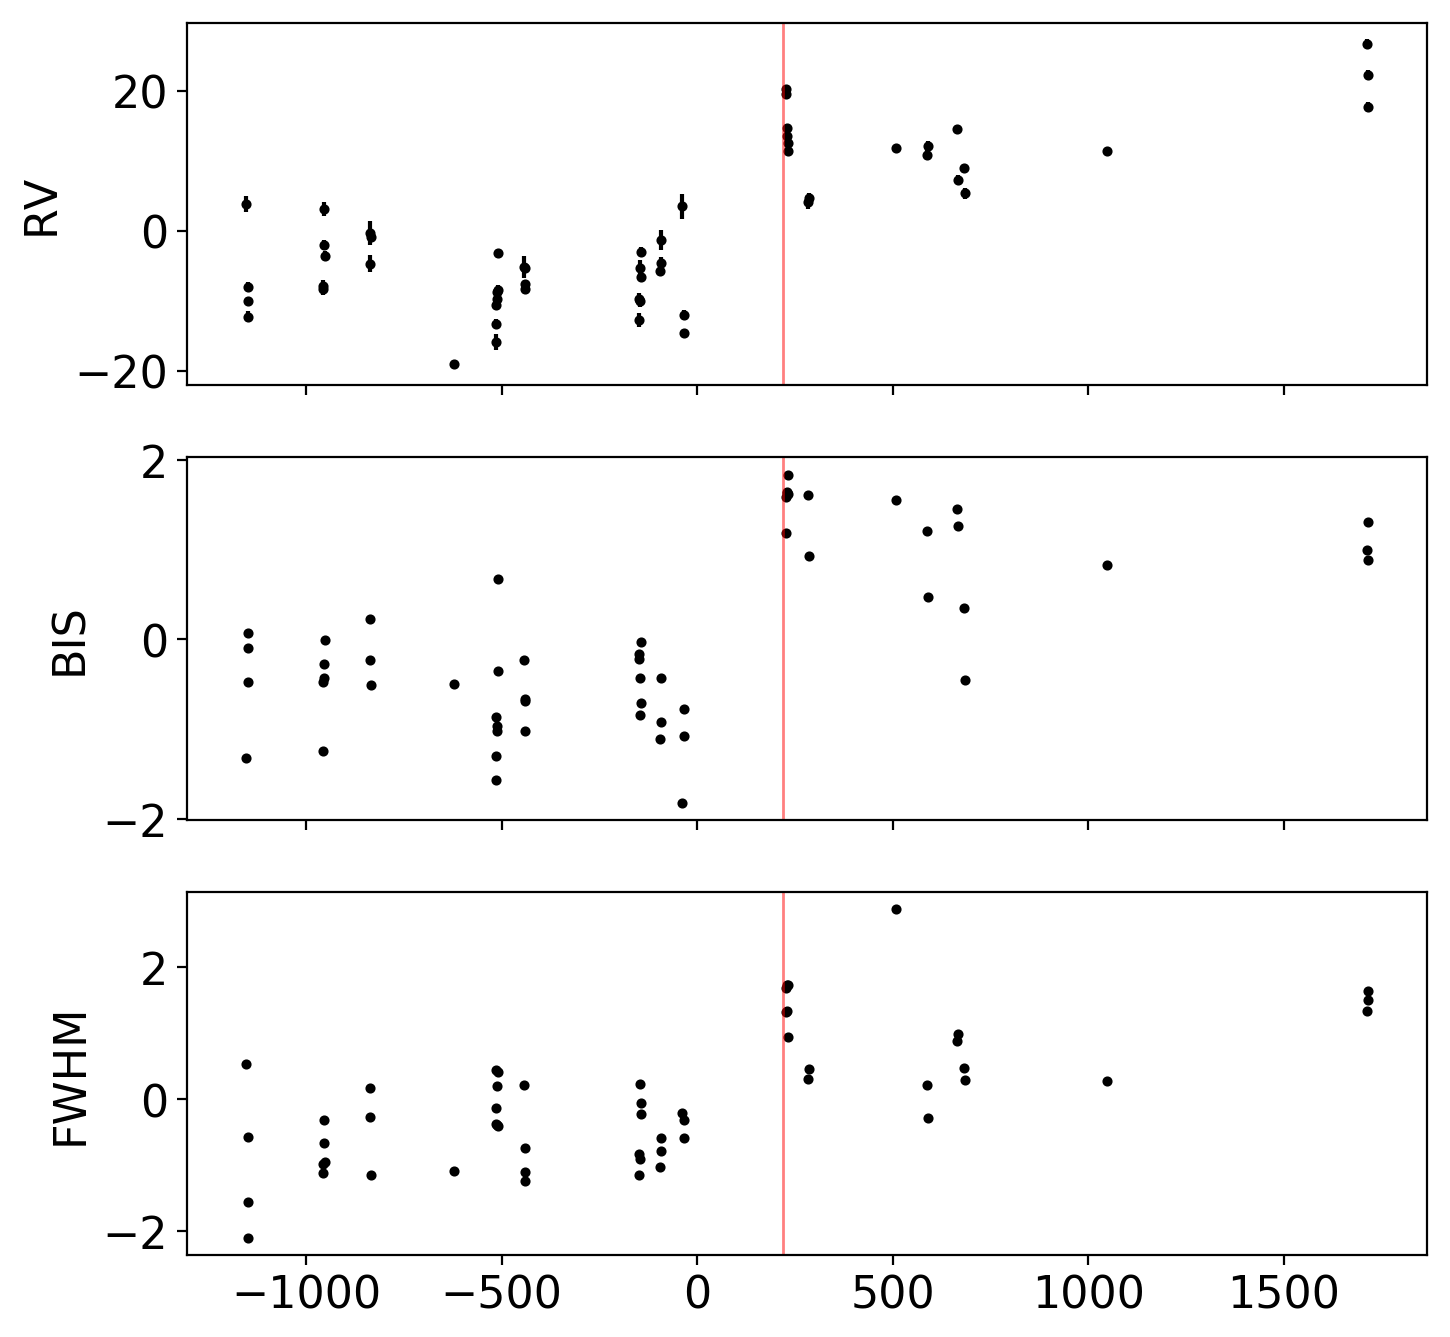

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8,8), sharex=True)
ax1.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
ax1.scatter(x_rv, y_rv, c='k', s=7)
ax1.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax1.set_ylabel('RV')

ax2.scatter(x_rv, bis_rv, c='k', s=7)
ax2.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax2.set_ylabel('BIS')

ax3.scatter(x_rv, fwhm_rv, c='k', s=7)
ax3.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax3.set_ylabel('FWHM');

peak at 34.5644 +/- 0.1316 days with log(power) = 2.85
peak at 99.7300 +/- 1.1296 days with log(power) = 2.80
peak at 1.0903 +/- 0.0001 days with log(power) = 2.74
peak at 59.1200 +/- 0.5363 days with log(power) = 2.67
peak at 1.0074 +/- 0.0001 days with log(power) = 2.69


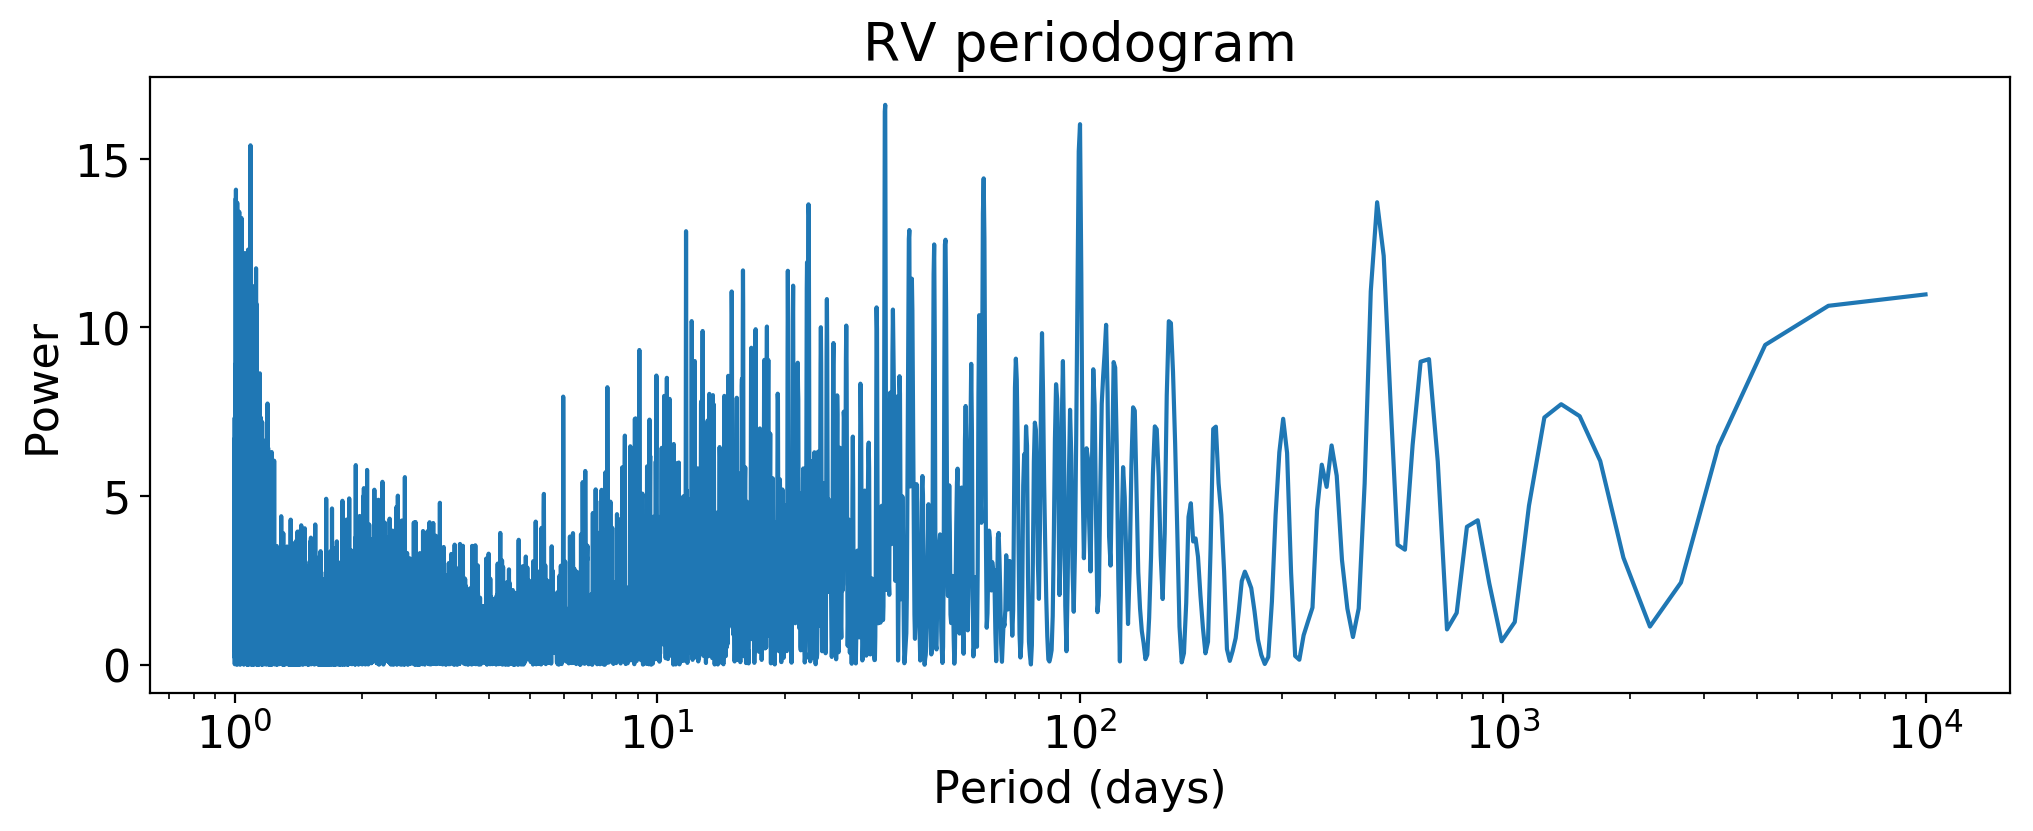

In [9]:
y_rv_guess = np.copy(y_rv)
y_rv_guess[pug] -= 15.4
pg = xo.lomb_scargle_estimator(x_rv, y_rv_guess, yerr=yerr_rv, min_period=1, max_period=1e4, max_peaks=5)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./pg['periodogram'][0], pg['periodogram'][1])
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
for p in pg['peaks']:
    print('peak at {0:.4f} +/- {1:.4f} days with log(power) = {2:.2f}'.format(p['period'], 
                                                                              p['period_uncert'], p['log_power']))

Pearson R is 0.3204 with a false-alarm probability of 0.0171


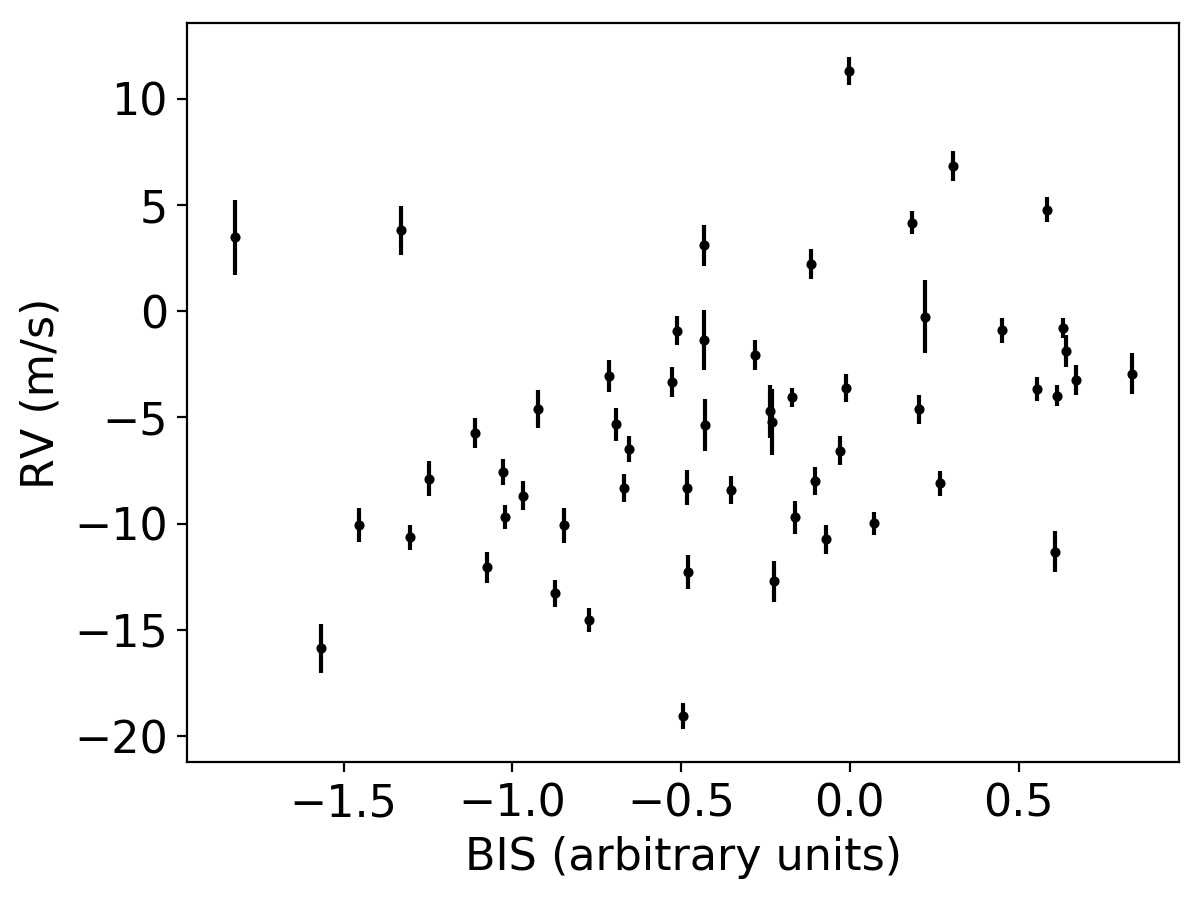

In [10]:
bis_rv_guess = np.copy(bis_rv)
bis_rv_guess[pug] -= 1.

plt.errorbar(bis_rv_guess, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(bis_rv_guess, y_rv_guess, c='k', s=7)
plt.xlabel('BIS (arbitrary units)')
plt.ylabel('RV (m/s)')

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(bis_rv_guess, y_rv_guess)))

Pearson R is 0.4587 with a false-alarm probability of 0.0004


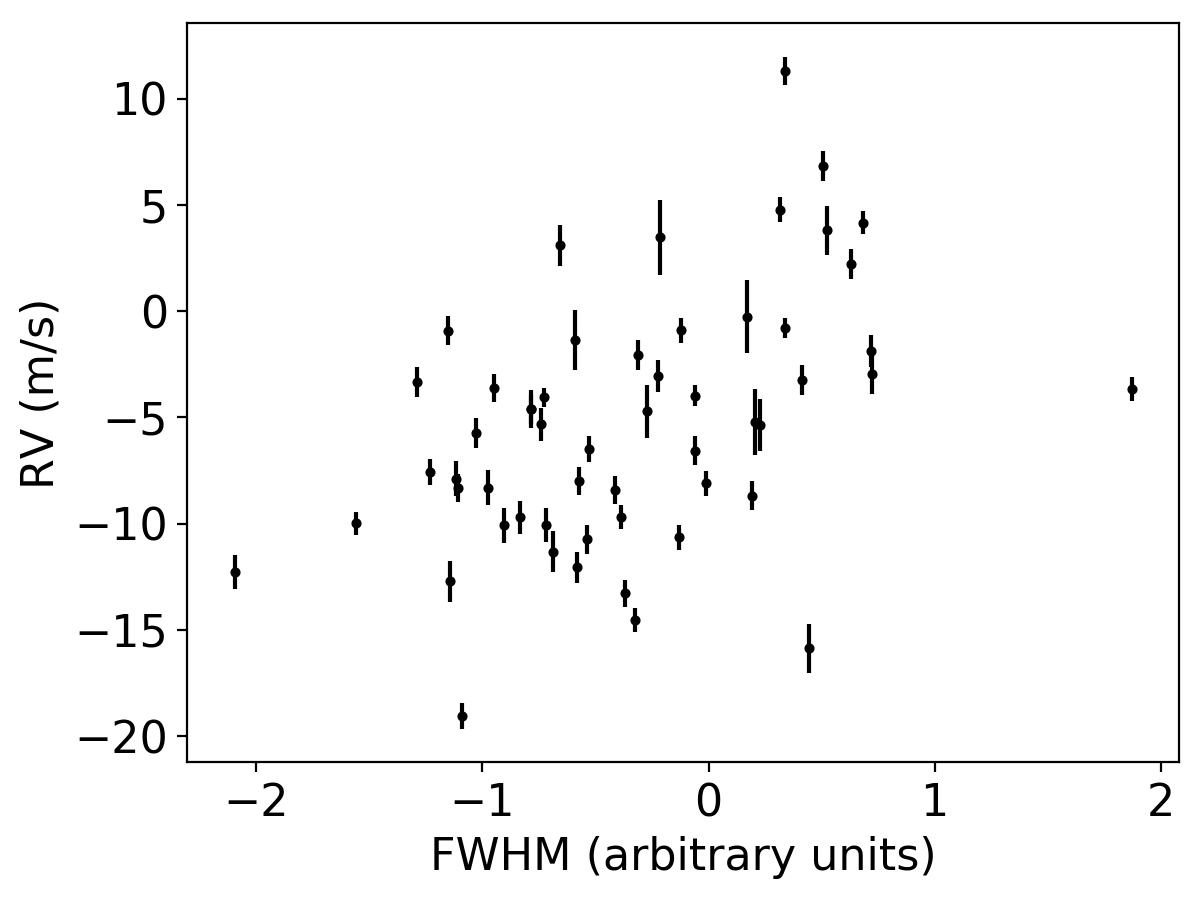

In [11]:
fwhm_rv_guess = np.copy(fwhm_rv)
fwhm_rv_guess[pug] -= 1.

plt.errorbar(fwhm_rv_guess, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(fwhm_rv_guess, y_rv_guess, c='k', s=7)
plt.xlabel('FWHM (arbitrary units)')
plt.ylabel('RV (m/s)')

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(fwhm_rv_guess, y_rv_guess)))

In [12]:
# starting guesses:
#periods = np.array([17.47114, 120.])
#t0s = np.array([1661.0628, 1000.])

periods = np.array([17.47114])
t0s = np.array([1661.0628])

n_pl = len(periods)

In [13]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = msini.to(u.M_earth)
print(msini)

[6.09623183] earthMass


In [22]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(start=None, bis=False, fwhm=False):
    with pm.Model() as model:

        # Stellar properties
        mr_star = pm.Bound(pm.MvNormal, lower=0)(
            "mr_star",
            mu=mass_radius_mu,
            chol=np.linalg.cholesky(mass_radius_cov),
            shape=2,
            testval=mass_radius_mu)
        m_star = pm.Deterministic("m_star", mr_star[0])
        r_star = pm.Deterministic("r_star", mr_star[1])
        
        # Planets
        log_period = pm.Normal("log_period", mu=np.log(periods), sd=10.0, shape=n_pl)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Uniform("t0", lower=t0s[0]-1.0, upper=t0s[0]+1.0, shape=n_pl)

        log_m_pl = pm.Bound(pm.Normal, lower=0.0)(
            "log_m_pl", mu=np.log(msini.value), sd=5, shape=n_pl)
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, testval=np.zeros(n_pl)+0.01, shape=n_pl)
        #ecc = xo.distributions.UnitUniform("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        omega = xo.distributions.Angle("omega", shape=n_pl)
        
        
        # RV jitter & a quadratic RV trend
        logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(3))[::-1], shape=3)
        if bis:
            offset_pug_bis = pm.Normal("offset_pug_bis", mu=1., sd=5) # weak prior from eyeballing
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
        if fwhm:
            offset_pug_fwhm = pm.Normal("offset_pug_fwhm", mu=1., sd=5) # weak prior from eyeballing
            trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
            
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0,
            ecc=ecc, omega=omega,
            m_planet=m_pl, 
            m_planet_units=msini.unit)

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv, 3)
        bkg_terms = tt.dot(A, trend) + pug*offset_pug
        if bis:
            A_bis = np.vander(bis_rv, 2)
            bkg_terms += tt.dot(A_bis, trend_bis) + pug*offset_pug_bis*trend_bis[0]
        if fwhm:
            A_fwhm = np.vander(fwhm_rv, 2)
            bkg_terms += tt.dot(A_fwhm, trend_fwhm) + pug*offset_pug_fwhm*trend_fwhm[0]            
        bkg = pm.Deterministic("bkg", bkg_terms)


        # The likelihood for the RVs
        if n_pl > 1:
            rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        else:
            rv_model = pm.Deterministic("rv_model", vrad + bkg)
        err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])

        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv, 3)
        pug_pred = t_rv >= HARPS_upgrade
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend) + pug_pred*offset_pug)
        if n_pl > 1:
            pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)
        else:
            pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug, trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis, offset_pug_bis])
        if fwhm:
            map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, offset_pug_fwhm])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = xo.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [23]:
model, map_soln = build_model()

optimizing logp for variables: ['offset_pug', 'trend', 'logs_rv_pug', 'logs_rv_pre']
54it [00:00, 131.45it/s, logp=-1.667304e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1686.413076804384 -> -166.7303698336715
optimizing logp for variables: ['t0_interval__', 'log_period']
15it [00:00, 44.97it/s, logp=-1.661713e+02] 
message: Optimization terminated successfully.
logp: -166.7303698336715 -> -166.17127429953365
optimizing logp for variables: ['log_m_pl_lowerbound__']
10it [00:00, 30.34it/s, logp=-1.625012e+02]
message: Optimization terminated successfully.
logp: -166.17127429953365 -> -162.50121502124682
optimizing logp for variables: ['trend', 'offset_pug', 'logs_rv_pug', 'logs_rv_pre', 'omega_angle__', 'ecc_interval__', 'log_m_pl_lowerbound__', 't0_interval__', 'log_period', 'mr_star_lowerbound__']
154it [00:00, 246.54it/s, logp=-1.342821e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -162.50121502124682 -> -134.2

In [24]:
map_soln['ecc']

array([0.40113175])

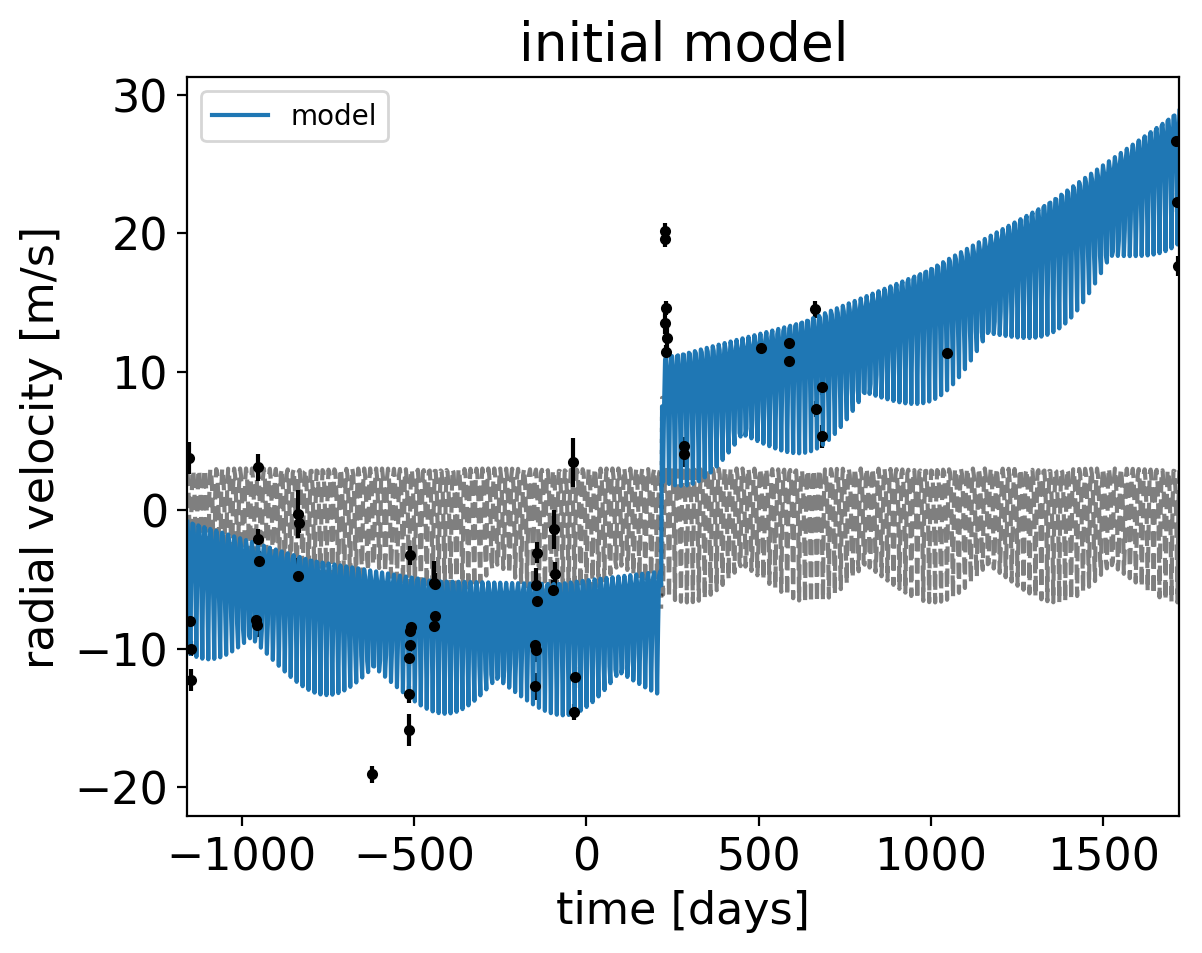

In [25]:
plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")

plt.plot(t_rv, map_soln['vrad_pred'], "--k", alpha=0.5)
plt.plot(t_rv, map_soln['bkg_pred'], ":k", alpha=0.5)
plt.plot(t_rv, map_soln['rv_model_pred'], label="model")

plt.legend(fontsize=10)
plt.xlim(t_rv.min(), t_rv.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

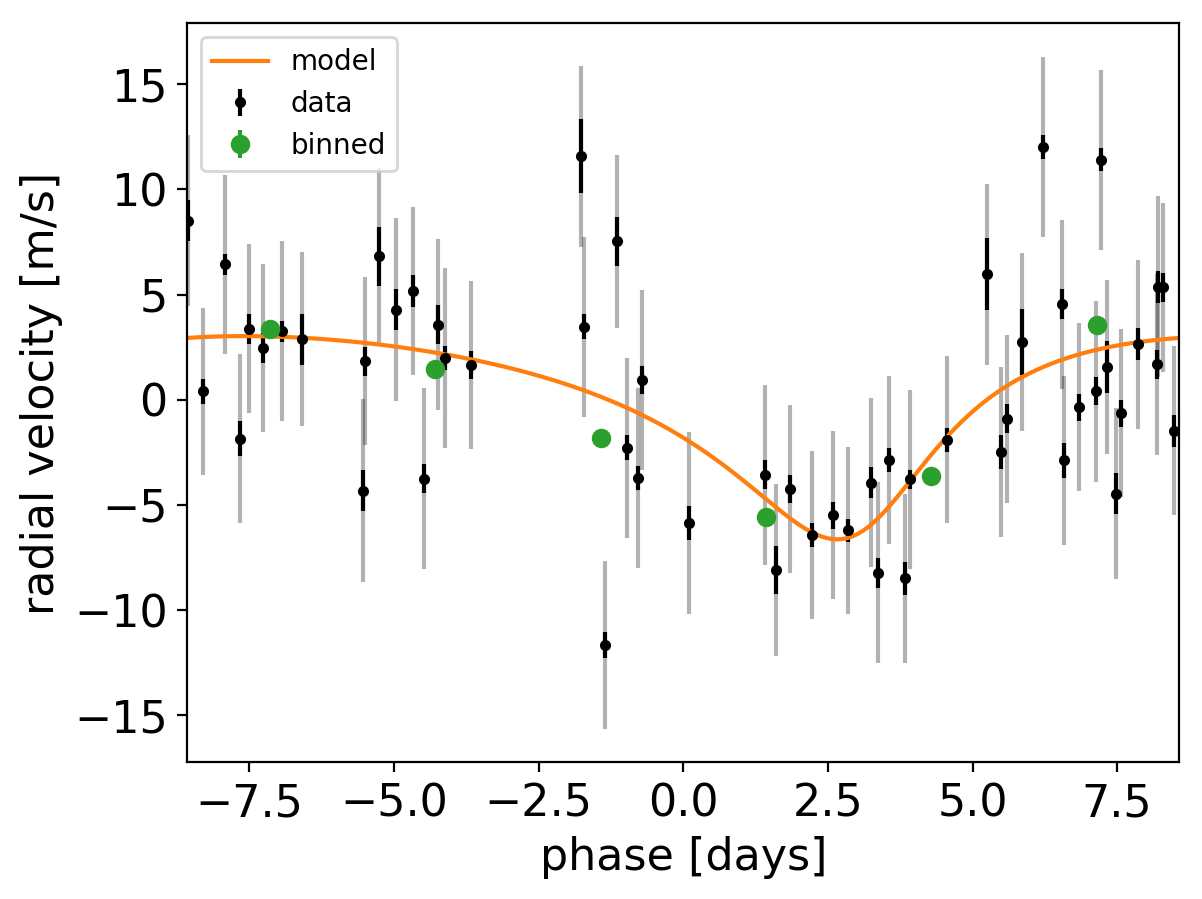

In [44]:
p = map_soln["period"]
t0 = map_soln["t0"]
jit2_pre = np.exp(2*map_soln["logs_rv_pre"])
jit2_pug = np.exp(2*map_soln["logs_rv_pug"])

bkg = map_soln["bkg"]

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

# Bin the data
bins = np.linspace(-0.5 * p, 0.5*p, 7).flatten()
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Plot the model prediction
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
plt.plot(t_fold[inds], map_soln['vrad_pred'][inds], color="C1", label="model")


plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]");